In [1]:
import functools
import os

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate, stats

In [3]:
import lib

In [4]:
def watermark(
    fig,
    text="preliminary",
):
    fig_width, fig_height = fig.get_size_inches()
    angle = np.degrees(np.arctan2(fig_height, fig_width))
    size = np.hypot(fig_width, fig_height) * 6 
    fig.text(
        0.5,
        0.5,
        text,
        color="k",
        alpha=0.1,
        fontsize=size,
        rotation=angle,
        horizontalalignment="center",
        verticalalignment="center",
    )

    return None

In [5]:
shear_step = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [6]:
redshift_sim = h5py.File(
    lib.const.REDSHIFT_CATALOGS[shear_step],
)

In [7]:
shear_sim = h5py.File(
    lib.const.IMSIM_CATALOGS[shear_step],
)

In [8]:
truth_match = h5py.File(
    lib.const.MATCH_CATALOGS[shear_step],
)

In [9]:
_, shear_sim_index, redshift_sim_index = np.intersect1d(
    shear_sim["mdet/noshear"]["uid"][:],
    redshift_sim["sompz/noshear"]["coadd_object_id"][:],
    return_indices=True,
)

In [10]:
np.testing.assert_equal(
    shear_sim["mdet/noshear"]["uid"][:][shear_sim_index],
    redshift_sim["sompz/noshear"]["coadd_object_id"][:][redshift_sim_index],
)

In [11]:
bhat_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
bhat_sim[shear_sim_index] = redshift_sim["sompz/noshear"]["bhat"][:][redshift_sim_index]

In [12]:
cell_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
cell_sim[shear_sim_index] = redshift_sim["sompz/noshear"]["cell_wide"][:][redshift_sim_index]

In [13]:
weights_sim = lib.weights.get_shear_weights(shear_sim["mdet/noshear"])

In [14]:
response_sim = lib.response.get_shear_response(shear_sim["mdet/noshear"])

In [15]:
cell_assignments = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments[tomographic_bin] = np.unique(
        cell_sim[bhat_sim == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments.values()
        ],
    )
) == 0

In [16]:
_Z = truth_match["mdet/noshear"]["z"][:]

---

In [17]:
from boyan import Tz, rebin

In [18]:
zbins_005 = np.arange(0, 6, 0.05)

zvals_005 = np.concatenate([[0], np.arange(0.035, 3, 0.05)])
zedges_005 = np.concatenate(
    [
        [0],
        np.linspace(
            0.0,
            3.0,
            len(zvals_005),
        ) + 0.01,
    ]
)

In [19]:

zbins_001 = np.arange(0, 6, 0.01)

zvals_001 = np.concatenate([[0], np.arange(0.005, 3, 0.01)])
zedges_001 = np.concatenate(
    [
        [0],
        np.linspace(
            0.0,
            3.0,
            len(zvals_001),
        ) + 0.01,
    ]
)

In [20]:
def rebin_001_to_005(nz):
    redshift_original = np.append(nz, np.array([0, 0]))
    zbinsc_laigle = np.arange(0, 3.02, 0.01)
    zbinsc_integrate = np.arange(0.015, 3.015, 0.01)

    interp_func = interpolate.interp1d(zbinsc_laigle, redshift_original, kind='linear', axis=0, bounds_error=False, fill_value=0)
    values = interp_func(zbinsc_integrate)


    values = values.reshape((60, 5))
    redshift_integrated = np.sum(values, axis=1)
    
    return redshift_integrated

In [21]:
def rebin_005_to_001(nz):
    redshift_original = np.append(nz, np.array([0, 0]))
    zbinsc_laigle = np.arange(0, 3.10, 0.05)
    zbinsc_integrate = np.arange(0.015, 3.015, 0.002)  # np.arange(0.015, 3.015, 0.05)

    interp_func = interpolate.interp1d(zbinsc_laigle, redshift_original, kind='linear', axis=0, bounds_error=False, fill_value=0)
    values = interp_func(zbinsc_integrate)


    values = values.reshape((300, 5))
    redshift_integrated = np.sum(values, axis=1)
    
    return redshift_integrated

In [22]:
t_005 = Tz(0.05, 60, z0=0.035)

In [23]:
t_001 = Tz(0.01, 300, z0=0.005)

---

In [24]:
nz_direct_005 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    _zedges_005 = np.copy(zedges_005)
    _zedges_005[-1] = np.inf  # pileup in last bin
    nz = np.histogram(Z, _zedges_005, weights=response_weight)[0]

    # #Pileup at z=3
    # idx = np.min(np.where(_zbins_005 >= 3)) - 1
    # nz[idx] = np.sum(nz[idx:])
    # nz = nz[:idx + 1]

    # nz = np.concatenate((np.array([0]), nz))

    nz[0] = 0
    nz_direct_005[tomographic_bin] = nz / np.sum(nz) / np.diff(zedges_005)
    

In [25]:
nz_rebin_005 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    nz = np.histogram(Z, zbins_001, weights=response_weight, density=True)[0]

    #Pileup at z=3
    idx = np.min(np.where(zbins_001 >= 3)) - 1
    nz[idx] = np.sum(nz[idx:])
    nz = nz[:idx + 1]

    #Convert to Tz and dz=0.05
    y = rebin_001_to_005(nz)
    dndz_true = t_005.dndz(y, zvals_005)
    
    nz_rebin_005[tomographic_bin] = dndz_true
    

In [26]:
print("mean z")
print(
    f"bin"
    f"\tdirect"
    f"\trebin"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zvals_005, weights=nz_direct_005[i]) :.4f}"
        "\t"
        f"\t{np.average(zvals_005, weights=nz_rebin_005[i]) :.4f}"
    )


mean z
bin	direct	rebin
0	0.3575		0.3513
1	0.5144		0.5090
2	0.7897		0.7843
3	1.0763		1.0698


In [27]:
print("dz")
print(
    f"bin"
    f"\trebin - direct"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zvals_005, weights=nz_rebin_005[i]) - np.average(zvals_005, weights=nz_direct_005[i]) :.4f}"
    )
 

dz
bin	rebin - direct
0	-0.0062
1	-0.0054
2	-0.0054
3	-0.0066


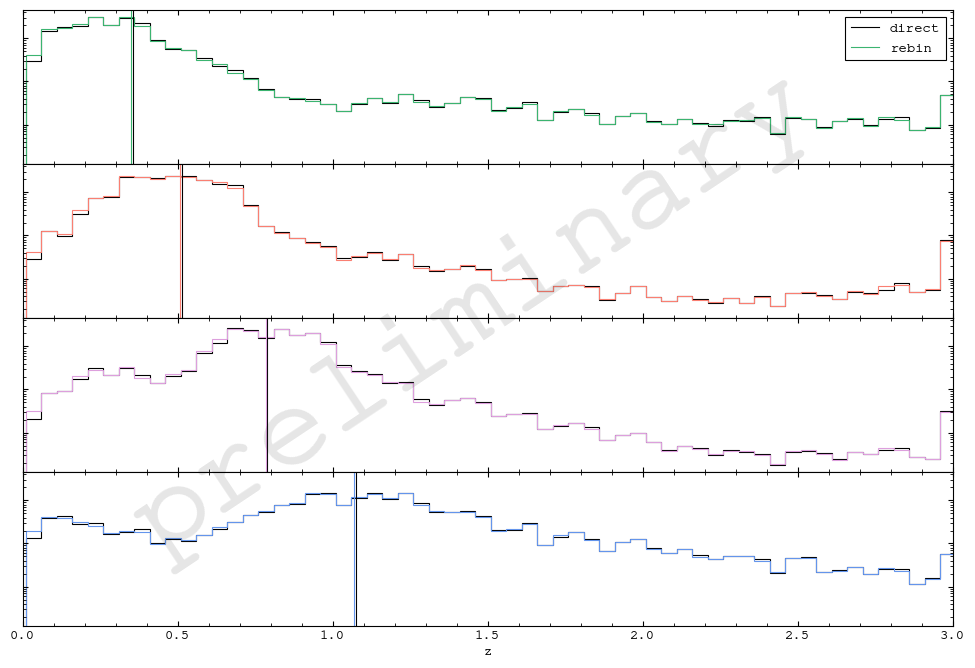

In [28]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zvals_005, weights=nz_direct_005[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_direct_005[i],
        edges=zedges_005,
        ec="k",
        ls="-",
        label="direct",
    )
    
    axs[i].axvline(
        np.average(zvals_005, weights=nz_rebin_005[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_rebin_005[i],
        edges=zedges_005,
        ec=tomo_colors[i],
        ls="-",
        label="rebin",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

---

In [29]:
nz_direct_001 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    _zedges_001 = np.copy(zedges_001)
    _zedges_001[-1] = np.inf  # pileup in last bin
    nz = np.histogram(Z, _zedges_001, weights=response_weight)[0]

    # #Pileup at z=3
    # idx = np.min(np.where(_zbins_005 >= 3)) - 1
    # nz[idx] = np.sum(nz[idx:])
    # nz = nz[:idx + 1]

    # nz = np.concatenate((np.array([0]), nz))

    nz[0] = 0
    nz_direct_001[tomographic_bin] = nz / np.sum(nz) / np.diff(zedges_001)
    

In [30]:
nz_rebin_001 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    nz = np.histogram(Z, zbins_005, weights=response_weight, density=True)[0]

    #Pileup at z=3
    idx = np.min(np.where(zbins_005 >= 3)) - 1
    nz[idx] = np.sum(nz[idx:])
    nz = nz[:idx + 1]

    #Convert to Tz and dz=0.01
    y = rebin_005_to_001(nz)
    dndz_true = t_001.dndz(y, zvals_001)
    
    nz_rebin_001[tomographic_bin] = dndz_true
    

In [31]:
print("mean z")
print(
    f"bin"
    f"\tdirect"
    f"\trebin"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zvals_001, weights=nz_direct_001[i]) :.4f}"
        "\t"
        f"\t{np.average(zvals_001, weights=nz_rebin_001[i]) :.4f}"
    )


mean z
bin	direct	rebin
0	0.3466		0.3204
1	0.5042		0.4763
2	0.7798		0.7514
3	1.0663		1.0405


In [32]:
print("dz")
print(
    f"bin"
    f"\trebin - direct"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zvals_001, weights=nz_rebin_001[i]) - np.average(zvals_001, weights=nz_direct_001[i]) :.4f}"
    )
 

dz
bin	rebin - direct
0	-0.0263
1	-0.0279
2	-0.0285
3	-0.0258


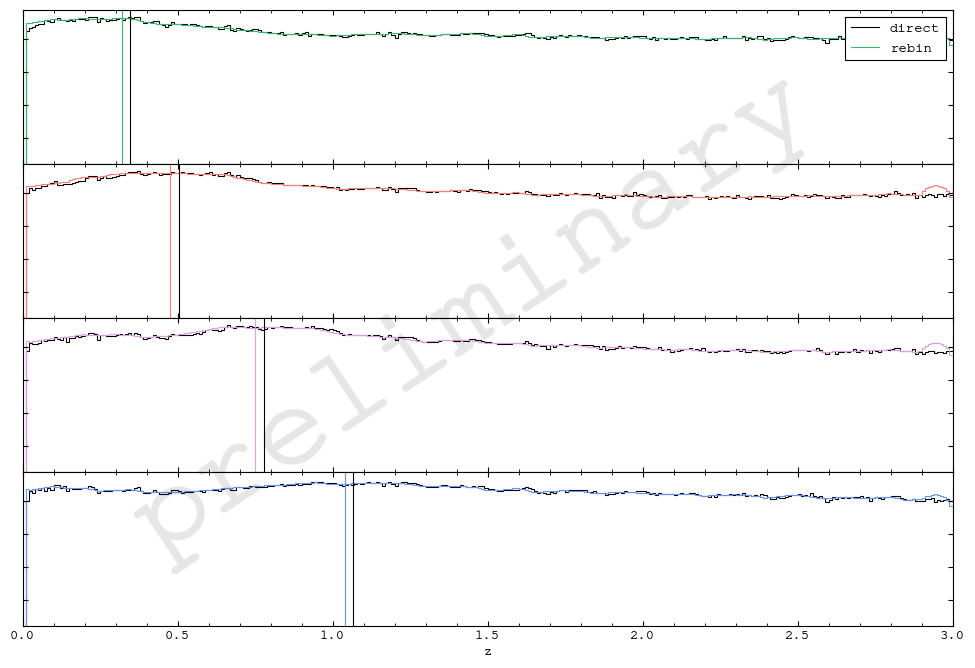

In [33]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zvals_001, weights=nz_direct_001[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_direct_001[i],
        edges=zedges_001,
        ec="k",
        ls="-",
        label="direct",
    )
    
    axs[i].axvline(
        np.average(zvals_001, weights=nz_rebin_001[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_rebin_001[i],
        edges=zedges_001,
        ec=tomo_colors[i],
        ls="-",
        label="rebin",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()